In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from simulator import smfe_simulator_mm
import config

In [1]:
import pytest
import numpy as np
from sbi_smfs.simulator.brownian_integrator import brownian_integrator
import matplotlib.pyplot as plt

/home/dingeldein/anaconda3/envs/sbi_smfs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


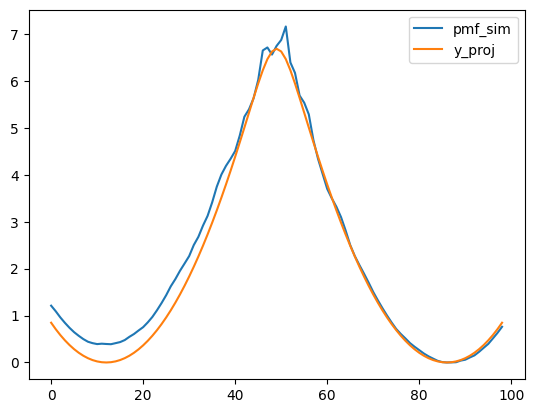

In [107]:

@np.vectorize
def G0(x):
    if np.abs(x) > 0.5:
        return 2 * (np.abs(x) - 1) ** 2 - 1
    else:
        return -2 * x ** 2


def G(x, q, dG=4, k=2, delta_x=1):
    return dG * G0(x / delta_x) + 0.5 * k * (x - q) ** 2


def test_integrator_pmf(deltaG: float, k: float, delta_x: float):
    x_knots = np.linspace(-550, 550, 550)
    y_knots = deltaG * G0(x_knots / delta_x)
    T = 1

    q = brownian_integrator(
        x0=0,
        q0=0,
        Dx=6.8,
        Dq=0.55,
        x_knots=x_knots,
        y_knots=y_knots,
        k=k,
        N=2000000,
        dt=0.1,
        fs=1,
    )
    if q is None:
        print("q is None")
        raise ValueError
    
    bins = np.linspace(-20.0, 20.0, 100)
    counts, bins = np.histogram(q, bins=bins, density=True)
    pmf_sim = -np.log(counts)
    pmf_sim = pmf_sim - min(pmf_sim)
    bin_center = bins[1:] - (bins[1:] - bins[:-1]) / 2

    x_values = np.linspace(-20, 20, len(bin_center))
    y_values = bin_center
    x, y = np.meshgrid(x_values, y_values)
    pot = G(x, y, dG=deltaG, k=k, delta_x=delta_x)

    L = len(pot[0, :])
    y_proj = np.zeros(L)
    for i in range(L):
        y_proj[i] = -np.log(np.trapz(np.exp(-pot[i, :])))
    y_proj = y_proj - min(y_proj)
    average_error = np.mean(y_proj - pmf_sim)
    #assert np.isclose(average_error, 0, atol=0.1)
    return pmf_sim, y_proj, average_error

pmf_sim, y_proj, error = test_integrator_pmf(9, 0.12, 15)
plt.plot(pmf_sim, label="pmf_sim")
plt.plot(y_proj, label="y_proj")
plt.legend()

(array([1.13572803e-06, 0.00000000e+00, 2.27145606e-06, 1.81716484e-05,
        4.54291211e-05, 9.19939703e-05, 2.68031815e-04, 6.01935855e-04,
        1.22317909e-03, 2.55198088e-03, 5.05966836e-03, 9.36521332e-03,
        1.67519884e-02, 2.83102926e-02, 4.56687597e-02, 7.08080996e-02,
        1.03862328e-01, 1.44766709e-01, 1.92562687e-01, 2.45034458e-01,
        2.97269997e-01, 3.42956928e-01, 3.76850460e-01, 3.95483214e-01,
        3.95052773e-01, 3.76991290e-01, 3.40976219e-01, 2.94903140e-01,
        2.43091227e-01, 1.90660343e-01, 1.43036995e-01, 1.01894111e-01,
        6.93941182e-02, 4.46840835e-02, 2.78366940e-02, 1.61205236e-02,
        9.16873237e-03, 4.99720332e-03, 2.46452982e-03, 1.18456433e-03,
        4.86091596e-04, 2.38502886e-04, 9.88083384e-05, 4.65648491e-05,
        1.24930083e-05, 1.24930083e-05, 2.27145606e-06, 0.00000000e+00,
        0.00000000e+00, 2.27145606e-06]),
 array([-5.27808603e+00, -5.05796285e+00, -4.83783967e+00, -4.61771649e+00,
        -4.3975933

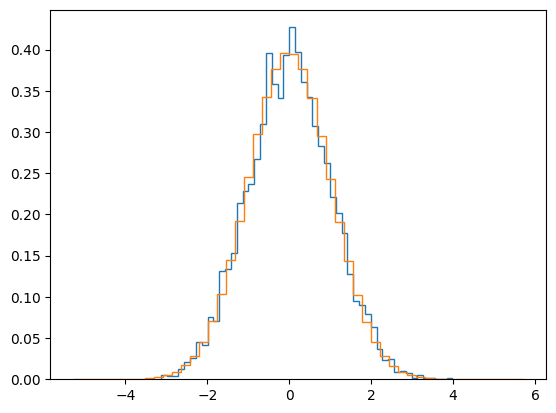

In [139]:
x_knots = np.linspace(-550, 550, 550)
y_knots = 9 * G0(x_knots / 15)
q = brownian_integrator(
    x0=0,
    q0=0,
    Dx=10,
    Dq=1,
    x_knots=x_knots,
    y_knots=y_knots,
    k=0.01,
    N=200000000,
    dt=0.00001,
    fs=50000,
)
q1 = brownian_integrator(
    x0=0,
    q0=0,
    Dx=10,
    Dq=1,
    x_knots=x_knots,
    y_knots=y_knots,
    k=0.01,
    N=4000000,
    dt=0.5,
    fs=1,
)
plt.hist(q[1:] - q[:-1], bins=50, density=True, histtype="step")
plt.hist(q1[1:] - q1[:-1], bins=50, density=True, histtype="step")

In [11]:
1e-3

0.001

In [ ]:
lower_limits = [
    config.logD_lims[0], config.k_lims[0],
    *(config.spline_lims[0] for i in range(config.N_knots_prior))
]

upper_limits = [
    config.logD_lims[1], config.k_lims[1],
    *(config.spline_lims[1] for i in range(config.N_knots_prior))
]

prior = utils.BoxUniform(
    low=torch.tensor(lower_limits),
    high=torch.tensor(upper_limits)
)

simulator, prior = prepare_for_sbi(smfe_simulator_mm, prior)

In [ ]:
num_sbc_runs = 2000  # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas, xs = simulate_for_sbi(
        simulator,
        prior,
        num_simulations=num_sbc_runs,
        num_workers=20,
        show_progress_bar=True
    )

In [ ]:
with open(f'../scr/mmatrix_posterior.pkl', 'rb') as handle:
    posterior = pickle.load(handle)

In [ ]:
num_posterior_samples = 2000
ranks, dap_samples = run_sbc(thetas, xs, posterior, num_posterior_samples=num_posterior_samples)

In [ ]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")

In [ ]:
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples, num_c2st_repetitions=10
)

In [ ]:
check_stats

In [ ]:
plt.hlines(0.5, xmin=0, xmax=13, color='red', linestyle='--')
plt.plot(check_stats['c2st_dap'], 'ob', color='green', label='C2ST DAP vs Prior')
plt.plot(check_stats['c2st_ranks'], 'ob', label='C2ST Ranks vs Uniform')
plt.ylim(1, 0.4)
plt.legend(fontsize=16)
_ = plt.xticks(ticks=np.arange(0, 13), labels=[r'$D_q/D_x$', '$k$', *(f'$G_0(x_{i})$' for i in range(11))], rotation='vertical', fontsize=16)
plt.ylabel('C2ST', fontsize=16)

In [ ]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=30,  # by passing None we use a heuristic for the number of bins.
)
